# I/ CONSTRUCTION OF THE SETS - SECTION

### Category Vocab Construction based on provided Keyword AND Construction of the positive set

##### Need to provide the keywords in the file label_name.txt
##### All the hyperparameters may be modified in the script agnews.sh

In [1]:
### Creating the folder
import os
keyword = 'all_names'
path = os.getcwd()+'/'+keyword+'/'


In [2]:
path

'/home/bastien/Documents/ProjetNLP/LOTClass/datasets/agnews/all_names/'

In [3]:
!cd ../.. && bash -x agnews.sh

+ export CUDA_DEVICE_ORDER=PCI_BUS_ID
+ CUDA_DEVICE_ORDER=PCI_BUS_ID
+ export CUDA_VISIBLE_DEVICES=0,1
+ CUDA_VISIBLE_DEVICES=0,1
+ DATASET=agnews
+ LABEL_NAME_FILE=label_names.txt
+ TRAIN_CORPUS=train.txt
+ TEST_CORPUS=test.txt
+ TEST_LABEL=test_labels.txt
+ TRAIN_LABEL=train_labels.txt
+ MAX_LEN=200
+ TRAIN_BATCH=32
+ ACCUM_STEP=4
+ EVAL_BATCH=128
+ GPUS=1
+ MCP_EPOCH=3
+ SELF_TRAIN_EPOCH=1
+ python src/train.py --dataset_dir datasets/agnews/ --label_names_file label_names.txt --train_file train.txt --train_label_file train_labels.txt --test_file test.txt --test_label_file test_labels.txt --max_len 200 --train_batch_size 32 --accum_steps 4 --eval_batch_size 128 --gpus 1 --mcp_epochs 3 --self_train_epochs 1
2020-11-27 13:21:52.260232: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Namespace(accum_steps=4, category_vocab_size=100, dataset_dir='datasets/agnews/', dist_port=12345, early_stop=False, eval_batch_size=128

In [4]:
!mkdir -p all_names
!mv *.pt all_names/

#### IMPORTS AND GLOBAL PARAMETER

In [6]:
import torch
from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import gc
from joblib import Parallel, delayed
import random
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.utils.data import Subset
import pickle as p
from tqdm import tqdm
import os
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_bert import BertOnlyMLMHead
from torch import nn
import sys
from tqdm import tqdm
from time import time
import pickle as p
import matplotlib.pyplot as plt

from collections import Counter
from nltk.util import ngrams 
from itertools import chain
from nltk.corpus import stopwords

positive_label = [0]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Statistics of the Positive Set

In [7]:
#### DATA FOLDER

In [51]:
mcp_data = torch.load(path+'mcp_train.pt')
assumed_label = []
for x in mcp_data['labels']:
    if (x!=-1).sum().item() < 2:
        assumed_label.append(((x!=-1)*x).sum().item())
    elif len(np.unique(x[x!=-1].numpy())) == 1:       
        assumed_label.append(np.unique(x[x!=-1].numpy())[0])
    else:
        assumed_label.append(-1)

In [52]:
ground = mcp_data['ground_truth'].numpy()
assumed_label = np.array(assumed_label)

In [53]:
import pandas as pd
df = pd.DataFrame([ground, assumed_label]).T
df.columns = ['ground','assumed']
df['valid'] = df['ground']==df['assumed']
precision = df.groupby('assumed')['valid'].sum()/df.groupby('assumed')['assumed'].count()

In [77]:
precision

assumed
0    0.563981
1    0.942857
2    0.633240
3    0.782821
dtype: float64

In [7]:
mcp_data = torch.load(path+'mcp_train.pt')
label = torch.LongTensor([1]).repeat(len(mcp_data['labels']))
import pandas as pd
number_of_correct_positives = pd.DataFrame(mcp_data['ground_truth'].numpy()).value_counts().values

In [8]:
# real positive over positive 
print("PRECISION of the positive set : ", number_of_correct_positives[0]/len(mcp_data['ground_truth']))
pos_set_accuracy = number_of_correct_positives[0]/len(mcp_data['ground_truth'])
print("NUMBER OF ELEMENTS in the positive set", len(mcp_data['ground_truth']))

PRECISION of the positive set :  0.7555228276877761
NUMBER OF ELEMENTS in the positive set 4074


#### DEFINITION OF THE MODEL 

In [9]:
class LOTClassModel(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config, add_pooling_layer=False)
        self.cls = BertOnlyMLMHead(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()
        # MLM head is not trained
        for param in self.cls.parameters():
            param.requires_grad = False
    
    def forward(self, input_ids, pred_mode, attention_mask=None, token_type_ids=None, 
                position_ids=None, head_mask=None, inputs_embeds=None):
        bert_outputs = self.bert(input_ids,
                                 attention_mask=attention_mask,
                                 token_type_ids=token_type_ids,
                                 position_ids=position_ids,
                                 head_mask=head_mask,
                                 inputs_embeds=inputs_embeds)
        last_hidden_states = bert_outputs[0]
        if pred_mode == "classification":
            trans_states = self.dense(last_hidden_states)
            trans_states = self.activation(trans_states)
            trans_states = self.dropout(trans_states)
            logits = self.classifier(trans_states)
        elif pred_mode == "mlm":
            logits = self.cls(last_hidden_states)
        else:
            sys.exit("Wrong pred_mode!")
        return logits

#### DEFINITION OF THE TOKENIZER FOR THE MODEL

In [85]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
vocab = tokenizer.get_vocab()
inv_vocab = {k:v for v, k in vocab.items()}

#### IMPORTING THE DATA AND PREPROCESSING

In [86]:
data_vocab = torch.load(path+"category_vocab.pt")
label_data = torch.load(path+"label_name_data.pt")
train_data = torch.load(path+'train.pt')

In [87]:
### TEXT AND LABELS LOADING AND FORMATING
corpus = open('train.txt', encoding="utf-8")
true_labels = open('train_labels.txt', encoding="utf-8")
docs_labels = [doc.strip() for doc in true_labels.readlines()]
dict_label = {0:[], 1:[], 2:[],3:[]}
list_label = [int(label) for label in docs_labels]
for i, label in enumerate(docs_labels):
    dict_label[int(label)].append(i)
docs = [doc.strip() for doc in corpus.readlines()]

In [88]:
### ALL KEYWORDS' RELATED WORD ARE STACKED TOGETHER as Tokens (integers)
category_vocab = []
for k in data_vocab.keys():
    category_vocab += list(data_vocab[k])

In [89]:
### CREATION OF THE LIST as Strings
list_pos_keyword = []
for w in category_vocab:
    list_pos_keyword.append(inv_vocab[w])

#### DEFINITION OF UTILITARY FUNCTIONS

In [90]:
def test(model, number = 1024, test_batch_size = 32,docs = docs, all = False, true_label = positive_label):
    model.eval()
    true_negative = 0
    true_positive = 0
    false_positive = 0
    false_negative = 0
    correct_pred = 0
    negative = 0
    divider = number
    if all:
        test_list = list(range(len(docs)))
        divider = len(docs)
    else:
        test_list = random.sample(list(range(len(docs))), k = number)
    inputs = torch.stack([encode(docs[i])[0].squeeze() for i in test_list])
    attention_mask = torch.stack([encode(docs[i])[1].squeeze() for i in test_list])
    true_labels = torch.stack([torch.tensor(int(list_label[i] in true_label)) for i in test_list])
    test_dataset = TensorDataset(inputs, attention_mask, true_labels)
    test_dataloader = DataLoader(test_dataset, batch_size = test_batch_size)
    with torch.no_grad():
        for batch in test_dataloader:
            inputs_test, attention_test, labels_test = batch
            logits = model(inputs_test.to(device),attention_mask=attention_test.to(device), pred_mode='classification')
            logits_cls = logits[:,0]
            prediction = torch.argmax(logits_cls, -1)
            
            true_positive += (prediction.cpu()*labels_test).sum().item()
            true_negative += ((1-prediction.cpu())*(1-labels_test)).sum().item()
            false_positive += ((prediction.cpu())*(1-labels_test)).sum().item()
            false_negative += ((1-prediction.cpu())*(labels_test)).sum().item()
            correct_pred += (labels_test == prediction.cpu()).sum().item()
            assert (correct_pred == (true_positive + true_negative))
        assert(true_positive+true_negative+false_positive+false_negative == divider)
        accuracy = correct_pred / divider
        
    if (true_positive+false_positive) > 0:
        precision = true_positive / (true_positive+false_positive)
        print('Precision', precision)
    else : 
        precision = None
        print("Precision Undefined")
    if (true_positive+false_negative) > 0 :
        recall = true_positive/(true_positive+false_negative)
        print('Recall', recall)
    else :
        recall = None
        print("Recall Undefined")
    if recall+precision > 0:
        f1_score = 2*(recall*precision)/(recall+precision)
        print("F1_score", f1_score)
    else:
        print("F1_score Undefined")
    print("Accuracy ", accuracy)
    model.train()
    return accuracy, precision, recall, f1_score



    
    
def encode(docs, tokenizer = tokenizer, max_length = 200):
    encoded_dict = tokenizer.encode_plus(docs, add_special_tokens=True, max_length=max_length, padding='max_length',
                                                    return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks



#### THESE ARE ONLY USED WHEN COMPUTING INTERSECTION ON GPUs
def intersect_tensor(t1, t2, device = 'cuda', mask = None):    
    indices = torch.zeros_like(t1, dtype = torch.uint8, device = device)
    for elem in t2:
        indices = indices | (t1 == elem) 
        indices = indices.to(bool)
        
    if mask is not None:
        indices = indices * mask 
    intersection = t1[indices]  
    return intersection, indices

def count_similar_words(batch, category_vocab = category_vocab):
    prediction= batch[0]
    input_mask = batch[1]
    masked_pred = prediction[:input_mask.sum().item(),:]
    _ , words = torch.topk(masked_pred, 8, -1)
    counter = 0
    for word in words.squeeze():
        counter += int(len(np.intersect1d(word.numpy(), category_vocab))>0)
        intersect_time = time() - intersect_time_start
        if counter > 0:
            print('break')
            return False
            break
    return True
            
def occurences(word, vocab = category_vocab):
    return len(np.intersect1d(word.cpu().numpy(), vocab))

def decode(ids, tokenizer=tokenizer):
    strings = tokenizer.batch_decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return strings



#### SELECTION OF TEXTS WITH NO KEYWORDS' RELATED WORDS

In [16]:
negative_doc=[]
negative_doc_label = []
for k, doc in tqdm(enumerate(docs)):
    tokenized_doc = tokenizer.tokenize(doc)
    new_doc = []
    wordpcs = []
    label_idx = -1 * torch.ones(512, dtype=torch.long)
    for idx, wordpc in enumerate(tokenized_doc):
        wordpcs.append(wordpc[2:] if wordpc.startswith("##") else wordpc)
        if idx >= 512 - 1: # last index will be [SEP] token
            break
        if idx == len(doc) - 1 or not doc[idx+1].startswith("##"):
            word = ''.join(wordpcs)
            if word in list_pos_keyword:
                label_idx[idx] = 0
                break
            new_word = ''.join(wordpcs)
            if new_word != tokenizer.unk_token:
                idx += len(wordpcs)
                new_doc.append(new_word)
            wordpcs = []
    if (label_idx>=0).any():
        continue
    else:
        negative_doc_label.append(list_label[k])
        negative_doc.append(doc)
    

120000it [01:08, 1761.08it/s]


#### Metrics of the Negative Set before the use of any language model

In [17]:
print("Negative pre-set", len(negative_doc))
print("Precision pre-set, ", len([k for k in negative_doc_label if k not in positive_label])/len(negative_doc_label))

Negative pre-set 64365
Precision pre-set,  0.8848753204381263


#### FORMATING THE NEGATIVE SET - ENCODING AND FORMATING INTO TENSORS

In [18]:
inputs_list = []
masks_list = []
for doc in tqdm(negative_doc):
    input_ids, input_mask = encode(doc)
    inputs_list.append(input_ids)
    masks_list.append(input_mask)
input_tensor = torch.stack(inputs_list).squeeze()
mask_tensor = torch.stack(masks_list).squeeze()
label_tensor = torch.stack([torch.tensor(i).unsqueeze(0) for i in negative_doc_label])
dataset = torch.utils.data.TensorDataset(input_tensor,mask_tensor, label_tensor)
dataloader = torch.utils.data.DataLoader(dataset, shuffle = False, batch_size = 8)

100%|██████████| 64365/64365 [00:35<00:00, 1824.58it/s]


#### CREATION OF MODEL AND HYPERPARAMETERS FOR THE FILTERING

In [19]:
model = LOTClassModel.from_pretrained('bert-base-uncased',
                                           output_attentions=False,
                                           output_hidden_states=False,
                                           num_labels=2).to('cuda')

verified_negative = []
correct_label = 0
verbose = True
topk = 15
vocab = torch.tensor(category_vocab).to(device)
min_similar_words = 0
max_category_word = 0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing LOTClassModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing LOTClassModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LOTClassModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LOTClassModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias', 'dense.weight', 'dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

#### COMPUTING THE NEGATIVE SET BASED ON THE PRETRAINED LANGUAGE MODEL

In [20]:
with torch.no_grad():
    for k, batch in tqdm(enumerate(dataloader)):

        input_ids, input_mask, label_id = batch
        predictions = model(input_ids.to(device),
                        pred_mode="mlm",
                        token_type_ids=None, 
                        attention_mask=input_mask.to(device))
        # Loop over the documents in the batch
        for i, doc in enumerate(predictions.cpu()):
            # Selecting only the position corresponding to a word not the PADDING
            masked_pred = doc[:input_mask[i].sum().item(),:]
            # Selecting the TOP 'k' words predicted at each position
            _ , words = torch.topk(masked_pred, topk, -1)
            counter = 0
            # Loop over the words in each document
            for word in words.squeeze():
                counter += int(len(np.intersect1d(word.cpu().numpy(), category_vocab))>min_similar_words)
                if counter > max_category_word:
                    break
            if counter <= max_category_word:             
                verified_negative.append(k*4+i)
                if label_id[i] not in positive_label:
                    correct_label += 1             
        if k%100 == 0 and verbose:
            if len(verified_negative)>0:
                print('accuracy :', correct_label/len(verified_negative))
                print('number of elements retrieved', len(verified_negative))


neg_set_accuracy = correct_label/len(verified_negative)    
        
        
    

102it [00:16,  6.17it/s]

accuracy : 0.9636363636363636
number of elements retrieved 55


202it [00:33,  5.88it/s]

accuracy : 0.975609756097561
number of elements retrieved 123


302it [00:50,  5.95it/s]

accuracy : 0.9723756906077348
number of elements retrieved 181


402it [01:07,  5.84it/s]

accuracy : 0.9730769230769231
number of elements retrieved 260


502it [01:24,  5.89it/s]

accuracy : 0.9771428571428571
number of elements retrieved 350


602it [01:41,  5.84it/s]

accuracy : 0.9805352798053528
number of elements retrieved 411


702it [01:58,  5.82it/s]

accuracy : 0.9786780383795309
number of elements retrieved 469


802it [02:15,  5.82it/s]

accuracy : 0.9751434034416826
number of elements retrieved 523


902it [02:32,  5.80it/s]

accuracy : 0.9783333333333334
number of elements retrieved 600


1002it [02:49,  5.66it/s]

accuracy : 0.977810650887574
number of elements retrieved 676


1102it [03:06,  5.88it/s]

accuracy : 0.9779917469050894
number of elements retrieved 727


1202it [03:24,  5.84it/s]

accuracy : 0.978343949044586
number of elements retrieved 785


1302it [03:41,  5.86it/s]

accuracy : 0.9791666666666666
number of elements retrieved 864


1402it [03:58,  5.91it/s]

accuracy : 0.977997799779978
number of elements retrieved 909


1502it [04:15,  5.93it/s]

accuracy : 0.9791666666666666
number of elements retrieved 960


1602it [04:32,  5.92it/s]

accuracy : 0.9782823297137216
number of elements retrieved 1013


1702it [04:49,  5.94it/s]

accuracy : 0.9775491113189897
number of elements retrieved 1069


1802it [05:06,  5.87it/s]

accuracy : 0.9768270944741533
number of elements retrieved 1122


1902it [05:23,  5.88it/s]

accuracy : 0.9769033361847733
number of elements retrieved 1169


2002it [05:40,  5.92it/s]

accuracy : 0.977850697292863
number of elements retrieved 1219


2102it [05:57,  5.92it/s]

accuracy : 0.978988326848249
number of elements retrieved 1285


2202it [06:14,  5.94it/s]

accuracy : 0.9802052785923754
number of elements retrieved 1364


2302it [06:31,  5.92it/s]

accuracy : 0.9811977715877437
number of elements retrieved 1436


2402it [06:48,  5.85it/s]

accuracy : 0.9819277108433735
number of elements retrieved 1494


2502it [07:05,  5.83it/s]

accuracy : 0.9825581395348837
number of elements retrieved 1548


2602it [07:22,  5.87it/s]

accuracy : 0.9825436408977556
number of elements retrieved 1604


2702it [07:39,  5.95it/s]

accuracy : 0.9826034793041392
number of elements retrieved 1667


2802it [07:56,  5.87it/s]

accuracy : 0.9826086956521739
number of elements retrieved 1725


2902it [08:13,  5.92it/s]

accuracy : 0.983249581239531
number of elements retrieved 1791


3002it [08:30,  5.78it/s]

accuracy : 0.9826558265582656
number of elements retrieved 1845


3102it [08:47,  5.89it/s]

accuracy : 0.9825489159175039
number of elements retrieved 1891


3202it [09:04,  5.93it/s]

accuracy : 0.9827147941026945
number of elements retrieved 1967


3302it [09:21,  5.90it/s]

accuracy : 0.9821073558648111
number of elements retrieved 2012


3402it [09:38,  5.92it/s]

accuracy : 0.9800292255236239
number of elements retrieved 2053


3502it [09:55,  5.99it/s]

accuracy : 0.9805502846299811
number of elements retrieved 2108


3602it [10:12,  5.86it/s]

accuracy : 0.9782909930715935
number of elements retrieved 2165


3702it [10:29,  5.92it/s]

accuracy : 0.9788383610986042
number of elements retrieved 2221


3802it [10:46,  5.87it/s]

accuracy : 0.9795296167247387
number of elements retrieved 2296


3902it [11:03,  5.81it/s]

accuracy : 0.9795221843003413
number of elements retrieved 2344


4001it [11:21,  5.58it/s]

accuracy : 0.9796257796257797
number of elements retrieved 2405


4102it [11:38,  5.88it/s]

accuracy : 0.9789217673287394
number of elements retrieved 2467


4202it [11:55,  5.94it/s]

accuracy : 0.9791666666666666
number of elements retrieved 2544


4302it [12:12,  5.84it/s]

accuracy : 0.9793656858998854
number of elements retrieved 2617


4402it [12:29,  5.89it/s]

accuracy : 0.9786116322701689
number of elements retrieved 2665


4502it [12:46,  5.86it/s]

accuracy : 0.9786056805606788
number of elements retrieved 2711


4602it [13:03,  5.96it/s]

accuracy : 0.9772972972972973
number of elements retrieved 2775


4702it [13:20,  5.91it/s]

accuracy : 0.9777070063694268
number of elements retrieved 2826


4802it [13:37,  5.88it/s]

accuracy : 0.9777391304347826
number of elements retrieved 2875


4902it [13:54,  5.90it/s]

accuracy : 0.9771798365122616
number of elements retrieved 2936


5002it [14:12,  5.86it/s]

accuracy : 0.9766042780748663
number of elements retrieved 2992


5102it [14:29,  5.91it/s]

accuracy : 0.9757058437294813
number of elements retrieved 3046


5202it [14:46,  5.90it/s]

accuracy : 0.975953831356204
number of elements retrieved 3119


5302it [15:02,  5.92it/s]

accuracy : 0.9755255726388453
number of elements retrieved 3187


5402it [15:20,  5.86it/s]

accuracy : 0.9753542821934689
number of elements retrieved 3246


5502it [15:37,  5.82it/s]

accuracy : 0.9748561042108452
number of elements retrieved 3301


5602it [15:54,  5.89it/s]

accuracy : 0.975356294536817
number of elements retrieved 3368


5702it [16:11,  5.97it/s]

accuracy : 0.974824355971897
number of elements retrieved 3416


5802it [16:28,  5.89it/s]

accuracy : 0.9746689694876224
number of elements retrieved 3474


5902it [16:45,  5.87it/s]

accuracy : 0.9747946757292552
number of elements retrieved 3531


6002it [17:02,  5.89it/s]

accuracy : 0.9751604800446553
number of elements retrieved 3583


6102it [17:18,  5.96it/s]

accuracy : 0.9755225522552256
number of elements retrieved 3636


6202it [17:35,  5.82it/s]

accuracy : 0.9754901960784313
number of elements retrieved 3672


6302it [17:52,  5.86it/s]

accuracy : 0.9752088385879817
number of elements retrieved 3711


6402it [18:09,  5.86it/s]

accuracy : 0.9750729249535932
number of elements retrieved 3771


6502it [18:26,  5.91it/s]

accuracy : 0.9753926701570681
number of elements retrieved 3820


6602it [18:43,  5.88it/s]

accuracy : 0.9755784061696658
number of elements retrieved 3890


6702it [19:00,  5.93it/s]

accuracy : 0.9753994420492011
number of elements retrieved 3943


6802it [19:17,  5.92it/s]

accuracy : 0.97475
number of elements retrieved 4000


6902it [19:34,  5.89it/s]

accuracy : 0.9750801875154207
number of elements retrieved 4053


7002it [19:51,  5.97it/s]

accuracy : 0.9754973313925279
number of elements retrieved 4122


7102it [20:08,  5.92it/s]

accuracy : 0.9749759384023099
number of elements retrieved 4156


7202it [20:25,  5.96it/s]

accuracy : 0.9750178443968593
number of elements retrieved 4203


7302it [20:42,  5.94it/s]

accuracy : 0.974900304949566
number of elements retrieved 4263


7402it [20:59,  5.90it/s]

accuracy : 0.9747392815758981
number of elements retrieved 4315


7502it [21:16,  5.93it/s]

accuracy : 0.9749021413769284
number of elements retrieved 4343


7602it [21:33,  5.98it/s]

accuracy : 0.9743473325766174
number of elements retrieved 4405


7702it [21:49,  5.95it/s]

accuracy : 0.9744852282900627
number of elements retrieved 4468


7802it [22:06,  5.89it/s]

accuracy : 0.9745406243081691
number of elements retrieved 4517


7902it [22:23,  5.86it/s]

accuracy : 0.9745502413339184
number of elements retrieved 4558


8002it [22:40,  5.90it/s]

accuracy : 0.9747826086956521
number of elements retrieved 4600


8046it [22:47,  5.88it/s]


#### EXPORT THE SET AND THE DATALOADER

In [21]:
p.dump(verified_negative, open(path+'verified_negative.p','wb'))
p.dump(dataloader, open(path+'dataloader.p','wb'))

# II/ TRAINING SECTION

#### LOADING OF THE SETS AND FORMATING

In [22]:
# Negative Set
new_verified_negative = p.load(open(path+'verified_negative.p','rb'))
new_dataloader = p.load(open(path+'dataloader.p','rb'))

# Positive Set
mcp_data = torch.load(path+'mcp_train.pt')
label = torch.LongTensor([1]).repeat(len(mcp_data['labels']))

# Formating
negative_dataset = Subset(new_dataloader.dataset, new_verified_negative)
positive_dataset = torch.utils.data.TensorDataset(mcp_data['input_ids'], mcp_data['attention_masks'], mcp_data['labels'])

## TO DO : Words statistics on both sets#

In [23]:
### STATISTICS ON CORPUS
corpus = open('train.txt', encoding="utf-8")
stopwords_vocab = stopwords.words('english')
lines = corpus.readlines()
words = chain.from_iterable(line.lower().split() for line in lines)
count = Counter(word for word in words if word not in stopwords_vocab)
count.most_common(55)

[('(', 41106),
 (')', 40787),
 ('-', 39111),
 ('#39;s', 31080),
 ('new', 21157),
 ('.', 18231),
 ('reuters', 17192),
 ('said', 16863),
 ('ap', 16080),
 ('us', 12047),
 ('first', 8934),
 ('two', 8867),
 ('--', 7958),
 ('oil', 6972),
 ('u.s.', 6924),
 ('world', 6843),
 ('one', 6746),
 ('last', 6237),
 ('company', 5900),
 ('york', 5543),
 ('inc.', 5480),
 ('president', 5458),
 ('microsoft', 5191),
 ('monday', 5038),
 ('#39;', 5022),
 ('united', 4979),
 ('wednesday', 4901),
 ('tuesday', 4834),
 ('could', 4826),
 ('would', 4767),
 ('three', 4765),
 ('thursday', 4754),
 ('million', 4710),
 ('says', 4508),
 ('afp', 4484),
 ('may', 4438),
 ('friday', 4290),
 ('government', 4260),
 ('iraq', 4221),
 ('security', 4212),
 ('game', 4152),
 ('prices', 4128),
 ('next', 4110),
 ('yesterday', 4110),
 ('group', 4043),
 ('corp.', 4015),
 ('people', 3893),
 ('quot;', 3891),
 ('time', 3756),
 ('software', 3753),
 ('back', 3730),
 ('percent', 3626),
 ('second', 3571),
 ('win', 3561),
 ('internet', 3486)]

#### CONSTRUCTION OF THE DATASETS AND OF THE WEIGHTED SAMPLER

In [24]:
####### Construction of the weighted sampler based on sets' sizes and of the target vector #########

target = np.hstack((np.zeros(int(len(negative_dataset)), dtype=np.int32),
                    np.ones(int(len(positive_dataset)), dtype=np.int32)))

class_sample_count = np.array([len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()


target = torch.from_numpy(target).long()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

#### DEFINTION OF THE BATCH SIZE


In [25]:
batch_size = 16

#### CONSTRUCTION OF THE DATALOADER

In [26]:
data = torch.stack([negative_data[0][:200] for negative_data in negative_dataset] + 
            [positive_data[0][:200] for positive_data in positive_dataset])

mask = torch.stack([negative_data[1][:200] for negative_data in negative_dataset] + 
            [positive_data[1][:200] for positive_data in positive_dataset])

train_dataset = torch.utils.data.TensorDataset(data,mask, target)

train_loader = DataLoader(train_dataset, batch_size = batch_size, sampler=sampler)

#### MODEL INSTANTIATION

In [27]:
model = LOTClassModel.from_pretrained('bert-base-uncased',
                                           output_attentions=False,
                                           output_hidden_states=False,
                                           num_labels=2).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing LOTClassModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing LOTClassModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LOTClassModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LOTClassModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias', 'dense.weight', 'dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

#### TRAINING HYPERPARAMETERS AND PARAMETERS

In [28]:
accum_steps = 8
epochs = 3
learning_rate = 1e-5
train_loss = nn.CrossEntropyLoss()
total_steps = len(train_loader) * epochs / accum_steps
number_of_mask = 1

parameters = {'epochs':epochs, 'learning_rate':learning_rate, 'number_of_mask':number_of_mask,
              'accum_steps':accum_steps, 
              'batch_size': batch_size, 
              'pos_set' : len(positive_dataset),
              'pos_set_accuracy' : pos_set_accuracy,
              'neg_set' : len(negative_dataset),
              'neg_set_accuracy' :neg_set_accuracy}


optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1*total_steps, num_training_steps=total_steps)

number_of_mask = 1 
# Metrics
losses_track = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
global_steps = []

#### TRAINING LOOP

In [29]:
model.train()
try:
    for i in range(epochs):
        model.train()
        total_train_loss = 0
        model.zero_grad()
        print('Epoch : ', i)
        for j, batch in enumerate(train_loader):
            input_ids = batch[0].to(device)
            input_mask = batch[1].to(device)
            labels = batch[2].to(device)


            ### RANDOM MASKING
            random_masking = random.choices(list(range(199)),k=number_of_mask*input_ids.size(0))
            for i, mask_pos in enumerate(random_masking):
                input_ids[i%input_ids.size(0),mask_pos+1] = tokenizer.get_vocab()[tokenizer.mask_token]
            
            ### PREDICTION
            logits = model(input_ids, 
                           pred_mode="classification",
                           token_type_ids=None, 
                           attention_mask=input_mask)
            ### LOSS
            logits_cls = logits[:,0]
            loss = train_loss(logits_cls.view(-1, 2), labels.view(-1)) / accum_steps            
            total_train_loss += loss.item()
            loss.backward()
            if (j+1) % accum_steps == 0:
                # Clip the norm of the gradients to 1.0.
                
                losses_track.append(loss*accum_steps)
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                model.zero_grad()
                
            if j % (3*accum_steps) == 0 :
                print('loss',loss*accum_steps)
                accuracy, precision, recall, f1_score = test(model, number = 1024)
                losses_track.append(loss*accum_steps)
                accuracies.append(accuracy)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1_score)
                global_steps.append(j)
        avg_train_loss = torch.tensor([total_train_loss / len(train_loader) * accum_steps]).to(device)
        print(f"Average training loss: {avg_train_loss.mean().item()}")

except RuntimeError as err:
    print(err)


Epoch :  0
loss tensor(0.6848, device='cuda:0', grad_fn=<MulBackward0>)
Precision 0.27303754266211605
Recall 0.6037735849056604
F1_score 0.3760282021151587
Accuracy  0.4814453125
loss tensor(0.6928, device='cuda:0', grad_fn=<MulBackward0>)
Precision 0.3063063063063063
Recall 0.604982206405694
F1_score 0.40669856459330145
Accuracy  0.515625
loss tensor(0.6855, device='cuda:0', grad_fn=<MulBackward0>)
Precision 0.2932330827067669
Recall 0.639344262295082
F1_score 0.4020618556701031
Accuracy  0.546875
loss tensor(0.6808, device='cuda:0', grad_fn=<MulBackward0>)
Precision 0.3691148775894539
Recall 0.7452471482889734
F1_score 0.4937027707808565
Accuracy  0.607421875
loss tensor(0.6557, device='cuda:0', grad_fn=<MulBackward0>)
Precision 0.4222222222222222
Recall 0.7723577235772358
F1_score 0.5459770114942528
Accuracy  0.69140625
loss tensor(0.6307, device='cuda:0', grad_fn=<MulBackward0>)
Precision 0.5851393188854489
Recall 0.7132075471698113
F1_score 0.6428571428571428
Accuracy  0.794921875

Precision 0.8145695364238411
Recall 0.4939759036144578
F1_score 0.615
Accuracy  0.849609375
loss tensor(0.0043, device='cuda:0', grad_fn=<MulBackward0>)
Precision 0.7705882352941177
Recall 0.5219123505976095
F1_score 0.6223277909738718
Accuracy  0.8447265625
loss tensor(0.0069, device='cuda:0', grad_fn=<MulBackward0>)
Precision 0.7719298245614035
Recall 0.4925373134328358
F1_score 0.6013667425968109
Accuracy  0.8291015625
loss tensor(0.0049, device='cuda:0', grad_fn=<MulBackward0>)
Precision 0.8292682926829268
Recall 0.4689655172413793
F1_score 0.5991189427312775
Accuracy  0.822265625
loss tensor(0.0172, device='cuda:0', grad_fn=<MulBackward0>)
Precision 0.7843137254901961
Recall 0.47619047619047616
F1_score 0.5925925925925926
Accuracy  0.8388671875
loss tensor(0.0037, device='cuda:0', grad_fn=<MulBackward0>)
Precision 0.8475609756097561
Recall 0.5018050541516246
F1_score 0.6303854875283447
Accuracy  0.8408203125
loss tensor(0.0087, device='cuda:0', grad_fn=<MulBackward0>)
Precision 0.

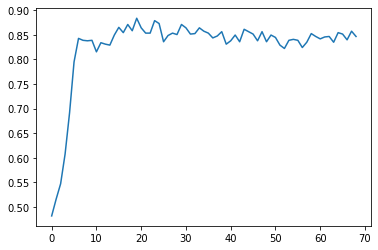

In [36]:

plt.plot(accuracies)

#### GLOBAL TEST

In [31]:
final_results = {}
res = test(model = model, all = True)
final_results['accuracy'] =  res[0]
final_results['precision'] = res[1]
final_results['recall'] = res[2]
final_results['f1_score'] = res[3]

Precision 0.7893627954779034
Recall 0.5120333333333333
F1_score 0.6211484027496967
Accuracy  0.84385


#### SAVE EVERYTHING

In [32]:
p.dump(accuracies,open(path+'accuracy.p','wb'))
p.dump(losses_track,open(path+'loss.p','wb'))
p.dump(precisions,open(path+'precision.p','wb'))
p.dump(recalls,open(path+'recall.p','wb'))
p.dump(f1_scores,open(path+'f1_score.p','wb'))
p.dump(parameters, open(path+'parameters.p', 'wb'))
p.dump(final_results, open(path+'final_results.p', 'wb'))

#### SAVE MODEL

In [33]:
torch.save(model.state_dict(), path+'model.pt')